<a href="https://colab.research.google.com/github/ankygupta9999/DL-image-captioning/blob/main/DL_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
import pandas as pd
import pickle
import os, re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet, resnet50
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

#Random seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

FILE_PATH = "/content/gdrive/MyDrive/bits/DL-assignment"
IMAGE_DATA_PATH = "/content/gdrive/MyDrive/bits/DL-assignment/Image_captioning_Dataset.zip"
CAPTIONS_PATH = os.path.join(FILE_PATH, "set_1.pkl")

In [5]:
# Download the dataset
# !unzip -q IMAGE_DATA_PATH
import zipfile

with zipfile.ZipFile(IMAGE_DATA_PATH, 'r') as zip_ref:
    zip_ref.extractall(os.curdir)

In [2]:
IMAGE_DATA_FOLDER = "Flicker8k_Dataset/"

In [3]:
# Method 1
objects = pd.read_pickle(CAPTIONS_PATH)
df = pd.DataFrame(objects)
print(type(df))
print(df)

<class 'pandas.core.frame.DataFrame'>
                                                       0
0      2089122314_40d5739aef.jpg#3\tA fluffy , tri-co...
1      1295671216_cde1b9c9d1.jpg#0\tA crowd of person...
2      3183195185_cd0ff994a1.jpg#4\tThe man and boy s...
3      2949353587_64c54e9589.jpg#1\tA brown dog be pl...
4      361092202_3d70144ebd.jpg#2\tA man hike with a ...
...                                                  ...
24995  3503623999_bbd5dcfb18.jpg#0\tA man in a crowd ...
24996  542405691_0594b1ce72.jpg#0\tA boy kick a ball ...
24997  1244485675_822e6efe60.jpg#1\tA boy look at his...
24998  475778645_65b7343c47.jpg#4\tA small child clim...
24999  381052465_722e00807b.jpg#4\tPeople put out a f...

[25000 rows x 1 columns]


In [4]:
objects[0]

'2089122314_40d5739aef.jpg#3\tA fluffy , tri-colored dog be run down a road with a paper in its mouth .'

In [5]:
len(objects)

25000

In [6]:
raw_df = pd.DataFrame()
for i, row in enumerate(objects):
  img_dict = {}
  img_dict['img_nm'] = str(row).split('#')[0]
  img_dict['caption_id'] = row.split(img_dict['img_nm'])[1].split('\t')[0]
  img_dict['img_caption'] = row.split('\t')[1]
  raw_df =raw_df.append(img_dict, ignore_index=True)
raw_df.head()

,caption_id,img_caption,img_nm
0,#3,"A fluffy , tri-colored dog be run down a road ...",2089122314_40d5739aef.jpg
1,#0,A crowd of person be stand together on a sidew...,1295671216_cde1b9c9d1.jpg
2,#4,"The man and boy sit on the ground , next to a ...",3183195185_cd0ff994a1.jpg
3,#1,A brown dog be play with a white fluffy stuff ...,2949353587_64c54e9589.jpg
4,#2,A man hike with a large backpack and two pole ...,361092202_3d70144ebd.jpg


In [7]:
raw_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   caption_id   25000 non-null  object
 1   img_caption  25000 non-null  object
 2   img_nm       25000 non-null  object
dtypes: object(3)
memory usage: 586.1+ KB


In [8]:
len(raw_df.img_nm.unique())

8033

In [9]:
len(os.listdir(IMAGE_DATA_FOLDER))

8091

In [10]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [11]:
def print_sample_imgs(img_dir, pics, nrows, ncols, nimages, df):
  nrows = nrows
  ncols = ncols

  # Index for iterating over images
  pic_index = 0
  # Set up matplotlib fig, and size it to fit 4x4 pics
  fig = plt.gcf()
  fig.set_size_inches(ncols * 6, nrows * 3)

  print("======================================================")
  print("============== Printing Sample images ================")
  print("======================================================")
  j = 1
  for i, img_nm in enumerate(pics):
    if i < nimages:
      # print ("printing {} , image :{}".format(i, img_nm))
      caption = list(df[df['img_nm'] == img_nm]['img_caption'])[0]
      just_img_nm = img_nm.split(sep='.')[0]
      # Set up subplot; subplot indices start at 1
      sp = plt.subplot(nrows, ncols, j)
      sp.axis('Off') # Don't show axes (or gridlines)
      sp.set_title("Img # "+ str(i+1) + " - Caption :" +caption, loc='left')
      raw_img_nm = img_dir + '/' + img_nm
      img = mpimg.imread(raw_img_nm)
      plt.imshow(img)

      j = j + 1
    else:
      break
  plt.show()

**Plot at least two samples and their captions (use matplotlib/seaborn/any other library).**

============== Printing Sample images ================


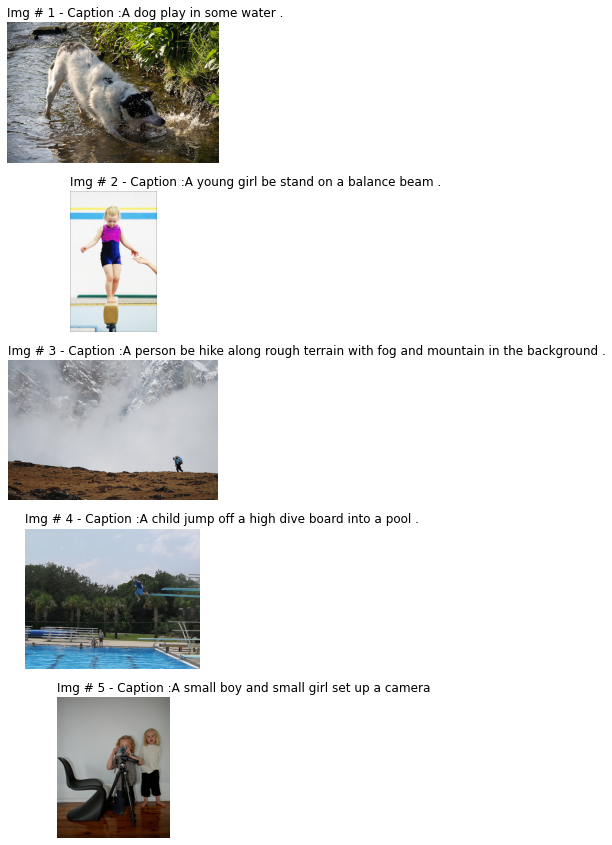

In [12]:
print_sample_imgs(IMAGE_DATA_FOLDER, os.listdir(IMAGE_DATA_FOLDER), nrows=5, ncols=1, nimages=5, df=raw_df)

In [13]:
def map_captions_images(captions_path, images_dir):
  captions_data = pd.read_pickle(captions_path)
  print('Captions data length = ', len(captions_data), '\n')

  captions_mapping = {} # dictionary mapping image names to captions
  captions_text = [] # list of all captions
  img_cnt = 0

  for i, row in enumerate(captions_data):
    img_name = str(row).split('#')[0] # get image name
    img_name = os.path.join(images_dir, img_name.strip()) # append image path
    img_caption = row.split('\t')[1] # get image caption

    if img_name.endswith("jpg"):
      img_caption = "<start> " + img_caption.strip() + " <end>" # add start & end token
      # captions_text.append(img_caption)
      
      if img_name in captions_mapping:
        # captions_mapping[img_name].append(img_caption)
        pass
      else:
        captions_text.append(img_caption) # to handle uneven caption list
        captions_mapping[img_name] = [img_caption]
        img_cnt = img_cnt + 1
  
  print('Total Images = ', img_cnt, '\n')

  return captions_mapping, captions_text

captions_mapping, captions_text = map_captions_images(CAPTIONS_PATH, IMAGE_DATA_FOLDER)

Captions data length =  25000 

Total Images =  8032 



In [14]:
len(captions_mapping)
len(captions_text)

8032

**Data Preparation**

In [15]:
import numpy as np

def train_val_split(captions_mapping, train_size=0.8, shuffle=True):
    image_names = list(captions_mapping.keys()) # list of all image names

    if shuffle:
        np.random.shuffle(image_names) # shuffle

    train_size = int(len(captions_mapping) * train_size) # split into training & validation

    training_data = {
        img_name: captions_mapping[img_name] for img_name in image_names[:train_size]
    }
    validation_data = {
        img_name: captions_mapping[img_name] for img_name in image_names[train_size:]
    }

    return training_data, validation_data

training_data, validation_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(training_data))
print("Number of validation samples: ", len(validation_data))

Number of training samples:  6425
Number of validation samples:  1607


In [16]:
# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 20

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Number of self-attention heads
NUM_HEADS = 2

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 15
AUTOTUNE = tf.data.AUTOTUNE
LEARNING_RATE = 0.0001

In [17]:
def get_cleaned_text(text):
    strip_chars = "!\"#$%&'()*+,-./:;=?@[\]^_`{|}~"
    text_lower = tf.strings.lower(text)
    return tf.strings.regex_replace(text_lower, "[%s]" % re.escape(strip_chars), "")


vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=get_cleaned_text,
)
vectorization.adapt(captions_text)

In [18]:
len(vectorization.get_vocabulary()) # Top vocabulary words

['',
 '[UNK]',
 'a',
 '<start>',
 '<end>',
 'in',
 'be',
 'on',
 'the',
 'dog',
 'and',
 'man',
 'with',
 'of',
 'two']

In [19]:
def read_image(img_path, size=IMAGE_SIZE):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def make_dataset(images, captions):
    img_dataset = tf.data.Dataset.from_tensor_slices(images).map(
        read_image, num_parallel_calls=AUTOTUNE
    )
    captions_rt = tf.ragged.constant(captions) # nested variable-length lists
    cap_dataset = tf.data.Dataset.from_tensor_slices(captions_rt).map(
        vectorization, num_parallel_calls=AUTOTUNE
    )
    print(captions_rt)
    dataset = tf.data.Dataset.zip((img_dataset, cap_dataset))
    dataset = dataset.batch(BATCH_SIZE).shuffle(256).prefetch(AUTOTUNE)
    return dataset

# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(training_data.keys()), list(training_data.values()))
valid_dataset = make_dataset(list(validation_data.keys()), list(validation_data.values()))

<tf.RaggedTensor [[b'<start> A group of person sit in a boat talk . <end>'], [b'<start> A young man be hold a drink and check his cellphone . <end>'], [b'<start> Man hold the hand of two child . <end>'], [b'<start> Four young woman wear bikini be play beach volleyball <end>'], [b'<start> One biker wear a black helmet ride on a dirt hill . <end>'], [b'<start> two child and their dog play in the snow . <end>'], [b'<start> A woman and two child walk through the upper level of a carnival attraction . <end>'], [b'<start> A man in bright orange short be skateboard along a course with cone as two person observe in the background . <end>'], [b'<start> A dog stand outside be look at the camera . <end>'], [b'<start> A man in white run while two officer follow . <end>'], [b'<start> A dog run through an obstacle course . <end>'], [b'<start> A young boy walk down a road with four turkey <end>'], [b'<start> Several dog swim in a pool and two black dog be play tug of war with a toy . <end>'], [b'<sta

In [20]:
len_list = []
for i , val in enumerate(training_data.values()):
    # print (len(val), val)
    len_list.append(len(val))

In [21]:
len_list.count(5)

0

**Model Building**

In [22]:
def get_cnn_model():
    base_model = resnet50.ResNet50(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, 1280))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = layers.Dense(embed_dim, activation="relu")
        self.layernorm_1 = layers.LayerNormalization()

    def call(self, inputs, training, mask=None):
        inputs = self.dense_proj(inputs)
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=None
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        return proj_input


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE)
        self.dropout_1 = layers.Dropout(0.1)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)
        inputs = self.dropout_1(inputs, training=training)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=combined_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        proj_out = self.layernorm_3(out_2 + proj_output)
        proj_out = self.dropout_2(proj_out, training=training)

        preds = self.out(proj_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=5,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                # 3. Pass image embeddings to encoder
                encoder_out = self.encoder(img_embed, training=True)

                batch_seq_inp = batch_seq[:, i, :-1]
                batch_seq_true = batch_seq[:, i, 1:]

                # 4. Compute the mask for the input sequence
                mask = tf.math.not_equal(batch_seq_inp, 0)

                # 5. Pass the encoder outputs, sequence inputs along with
                # mask to the decoder
                batch_seq_pred = self.decoder(
                    batch_seq_inp, encoder_out, training=True, mask=mask
                )

                # 6. Calculate loss and accuracy
                caption_loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
                caption_acc = self.calculate_accuracy(
                    batch_seq_true, batch_seq_pred, mask
                )

                # 7. Update the batch loss and batch accuracy
                batch_loss += caption_loss
                batch_acc += caption_acc

            # 8. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 9. Get the gradients
            grads = tape.gradient(caption_loss, train_vars)

            # 10. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        loss = batch_loss
        acc = batch_acc / float(self.num_captions_per_image)

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            # 3. Pass image embeddings to encoder
            encoder_out = self.encoder(img_embed, training=False)

            batch_seq_inp = batch_seq[:, i, :-1]
            batch_seq_true = batch_seq[:, i, 1:]

            # 4. Compute the mask for the input sequence
            mask = tf.math.not_equal(batch_seq_inp, 0)

            # 5. Pass the encoder outputs, sequence inputs along with
            # mask to the decoder
            batch_seq_pred = self.decoder(
                batch_seq_inp, encoder_out, training=False, mask=mask
            )

            # 6. Calculate loss and accuracy
            caption_loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
            caption_acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)

            # 7. Update the batch loss and batch accuracy
            batch_loss += caption_loss
            batch_acc += caption_acc

        loss = batch_loss
        acc = batch_acc / float(self.num_captions_per_image)

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(
    embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=NUM_HEADS
)
decoder = TransformerDecoderBlock(
    embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=NUM_HEADS
)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder
)

**Model Training**

In [ ]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Compile the model
caption_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=cross_entropy
)

# Fit the model
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/15


**Model Predicting**

In [ ]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


def generate_caption():
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = read_image(sample_img)
    img = sample_img.numpy().astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == " <end>":
            break
        decoded_caption += " " + sampled_token

    print("PREDICTED CAPTION:", end=" ")
    print(decoded_caption.replace("<start> ", "").replace(" <end>", "").strip())


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()